In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

%matplotlib inline


image_bank = {}

In [131]:
def get_image(filename='img/test_image2.png'):
    if filename in image_bank.keys():
        return image_bank[filename]
    
    img = cv2.imread(filename)
    image_bank[filename] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image_bank[filename]


 
def plot_image(images, title=None, labels=None, size=(12, 3)):
    if not isinstance(images, list):
        images = [images]
 
    if not isinstance(labels, list):
        labels = []
 
    fig, axs = plt.subplots(1, len(images), figsize=size,  dpi=150)
 
    if title is not None:
        fig.suptitle(title, fontsize=16)
    need_titles = len(labels) == len(images)
    for i, image in enumerate(images):
        ax = axs[i] if len(images) > 1 else axs
 
        if need_titles:
            ax.set_title(labels[i])
        ax.imshow(image, cmap='gray')
        ax.axis('off')

        
def fft(img):
    return np.fft.fft2(img)


def shift(img):
    return np.fft.fftshift(img)


def log_norm(img):
    with np.errstate(divide='ignore'): 
        return 20 * np.log(np.abs(img))
    
    


def return_to_image(f):
    return reverse(np.abs(fft(f)))


def reverse(image):
    return image[::-1, ::-1]


def ideal_filter_kernel(image_size, inner_field):
    center = image_size[0] // 2, image_size[1] // 2
    inner_size = inner_field.shape
    left = center[0] - inner_size[0] // 2, center[1] - inner_size[1] // 2
    
#     print(center)
#     print(inner_size)
#     print(left)
    
    kernel = np.zeros(image_size)
    kernel[left[0]:left[0]+inner_size[0], left[1]:left[1]+inner_size[1]] = inner_field
    return kernel
    
    
def ellipse(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size)

original image size = (528, 546)


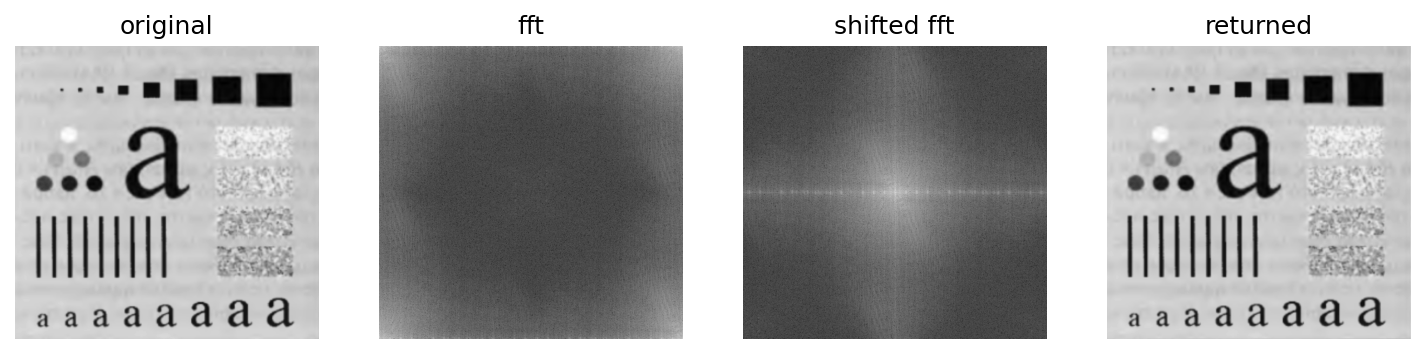

In [132]:
def show_original():
    f = fft(get_image())
    print(f'original image size = {get_image().shape}')
    normed = log_norm(f)
    shifted = shift(f)
    plot_image([get_image(), normed, log_norm(shifted), reverse(np.abs(fft(f)))],
              labels=[ 'original', 'fft', 'shifted fft', 'returned' ])
    
    
show_original()

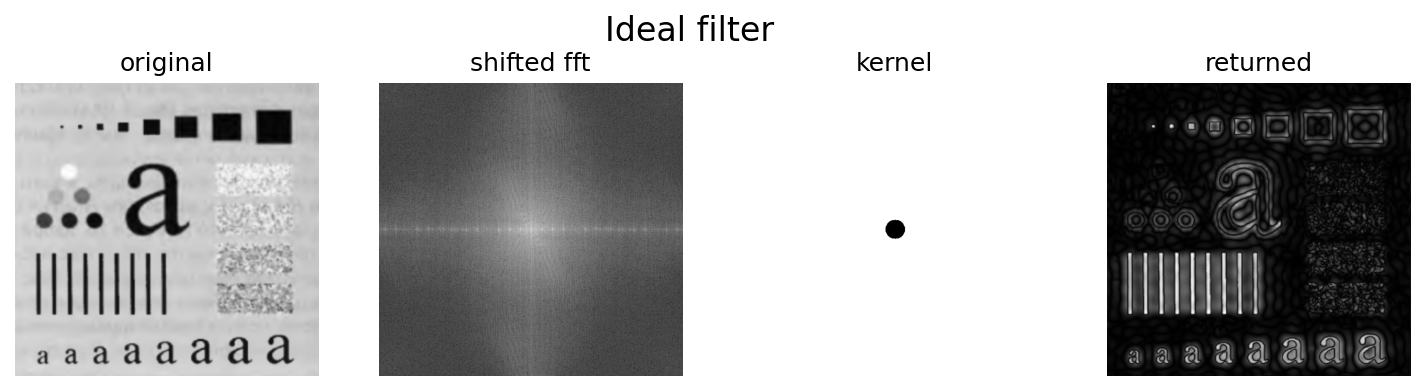

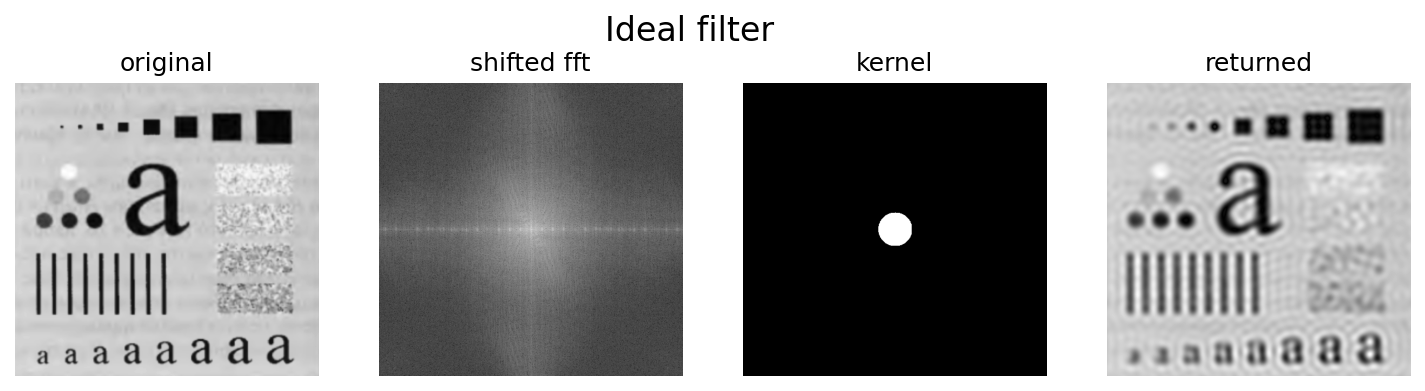

In [143]:
def ideal_lff_filter():
    original = get_image()
    kernel = ideal_filter_kernel(original.shape, ellipse((60, 60)))
    f = fft(original) 
    shifted = shift(f)
    filtered = shifted * kernel
    plot_image([original, log_norm(shifted), kernel, reverse(np.abs(fft(filtered)))],
              labels=[ 'original', 'shifted fft', 'kernel', 'returned' ],
              title='Ideal filter')

    
ideal_lff_filter()

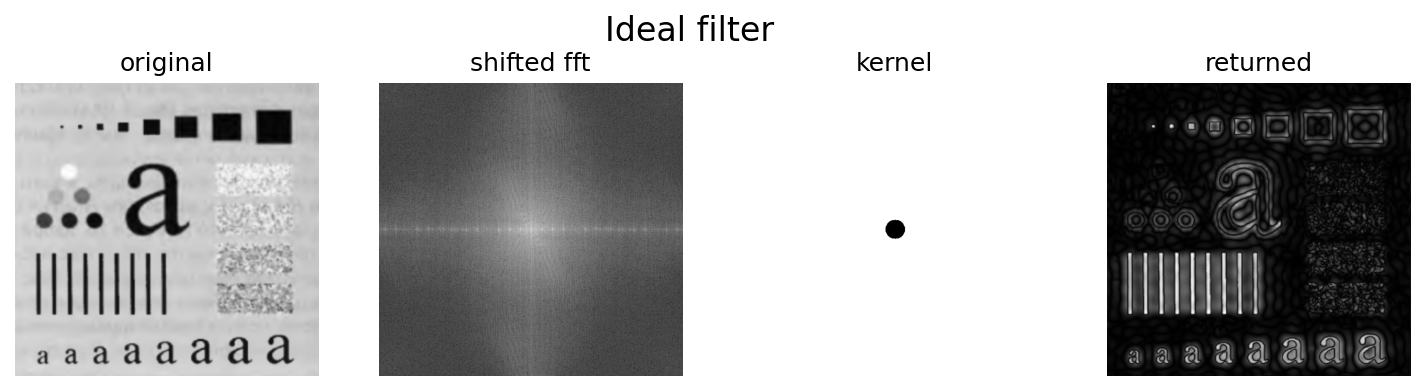

In [142]:
def ideal_hff_filter():
    original = get_image()
    kernel = 1 - ideal_filter_kernel(original.shape, ellipse((35, 35)))
    f = fft(original) 
    shifted = shift(f)
    filtered = shifted * kernel
    plot_image([original, log_norm(shifted), kernel, reverse(np.abs(fft(filtered)))],
              labels=[ 'original', 'shifted fft', 'kernel', 'returned' ],
              title='Ideal filter')

    
ideal_hff_filter()